## Importing Libraries

In [2]:
import numpy as np
import os
from skimage import io

from skimage.transform import rescale, resize
import datetime
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

import random as rn
import matplotlib.pyplot as plt

np.random.seed(30)
rn.seed(30)

## Importing Dataset

In [5]:
main_folder = 'datasets/Project_data'

train_folder = main_folder + '/train'
val_folder = main_folder + '/val'

In [7]:
train_doc = np.random.permutation(open(main_folder + '/train.csv').readlines())
val_doc = np.random.permutation(open(main_folder + '/val.csv').readlines())
batch_size = 32

enable_augmentation = False 
seq_idx = range(7,26,2)

dim_x, dim_y = 120, 120

In [9]:
datagen = ImageDataGenerator(
    brightness_range=[0.2,1.0],
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest")

In [10]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, sharey=True, figsize=(15, 5))
    
    for i, (ax, image) in enumerate(zip(axes, images)):
        ax.imshow(image, cmap)
        ax.axis('off')
        if captions:
            ax.set_title(captions[i])

In [11]:
def crop_image(image):
     if image.shape[1] > image.shape[0]:
        diff_px = image.shape[1] - image.shape[0]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[0]
        cropped_image = image[:, crop_start:crop_end]
     elif image.shape[0] > image.shape[1]:
        diff_px = image.shape[0] - image.shape[1]
        crop_start = diff_px//2
        crop_end = crop_start + image.shape[1]
        cropped_image = image[:, crop_start:crop_end]

     return cropped_image

## Generator

In [12]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train=False, augmentation=False, debug=False):
    img_idx = seq_idx  # Images to read
    x = len(img_idx)
    y, z = dim_x, dim_y
    
    while True:
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if len(t) % batch_size == 0:
            num_batches = int(len(t) / batch_size)
        else:
            num_batches = len(t) // batch_size + 1
            
        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size, x, y, z, 3)) 
            batch_labels = np.zeros((batch_size, 5))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                if debug:
                    plt.figure(figsize=(20, 5))
              
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(os.path.join(source_path, folder_str.split(';')[0])) 
               
                for idx, item in enumerate(img_idx): 
                    filename = os.path.join(source_path, folder_str.strip().split(';')[0], imgs[item])

                    image = io.imread(filename).astype(np.float32)

                    if debug:
                        plt.subplot(2, x, idx + 1)
                        plt.imshow(image.astype('uint8'))
       
                    image = crop_image(image=image)

                    resized_im = resize(image, output_shape=(120, 120))
                
                    if augmentation and is_train:
                        resized_im = next(datagen.flow(np.expand_dims(resized_im, axis=0), batch_size=1))[0]
                    if debug:
                        plt.subplot(2, x, idx + x + 1)
                        plt.imshow(resized_im.astype('uint8'))

                    # Normalize images
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255 
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255 
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255 

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels

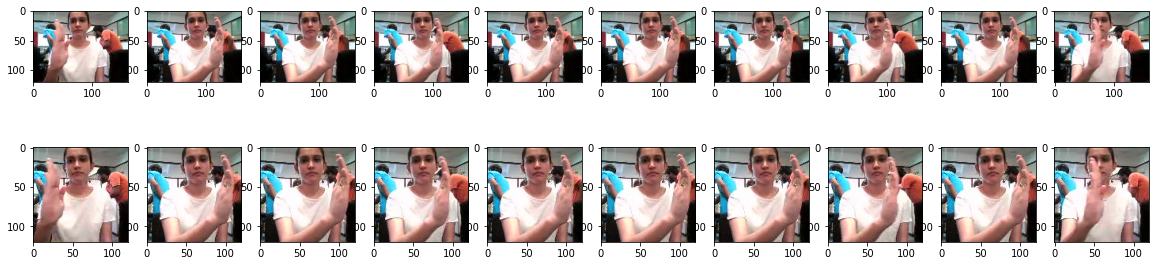

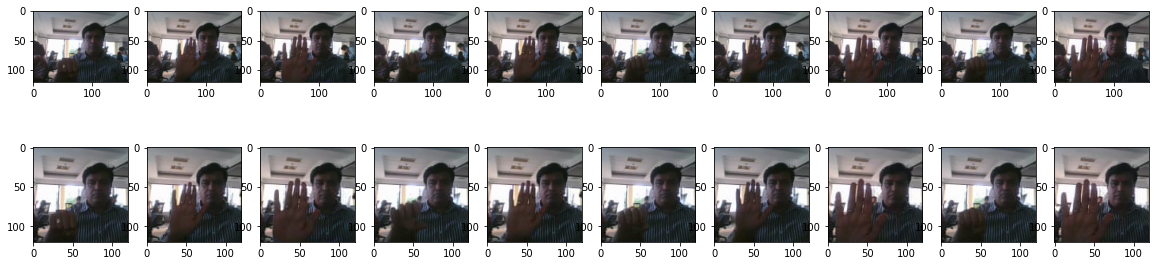

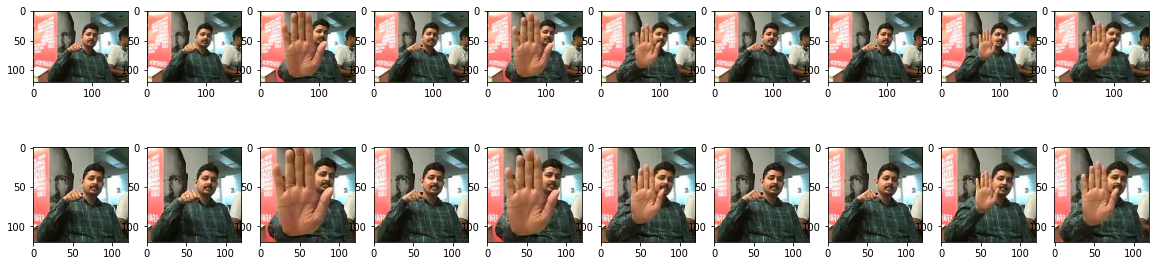

In [13]:
test_gen = generator(train_folder, train_doc, 3, is_train = True, augmentation=False, debug = True)

xx = next(test_gen)

In [14]:
current_date_time = datetime.datetime.now()
train_dataset_path = train_folder
val_dataset_path =  val_folder

# Multiply the number of training sequences by 2 when using augmentation
augmentation_multiplier = 1
if enable_augmentation:
    augmentation_multiplier = 2
num_train_sequences = len(train_doc) * augmentation_multiplier
print('training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('Number of validation sequences =', num_val_sequences)

num_epochs = 30 
print('epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Modelling

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [16]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

2024-02-06 20:21:46.140386: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-06 20:21:46.141156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [19]:
optimiser = Adam(learning_rate=0.001) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 128)   0

In [20]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_init_exp_02' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30


2024-02-06 20:25:09.643397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.2649 - categorical_accuracy: 0.4509
Epoch 00001: saving model to model_init_exp_02_2024-02-0620_21_19.404987/model-00001-2.26492-0.45089-28.99029-0.21094.h5
21/21 [==============================] - 65s 3s/step - loss: 2.2649 - categorical_accuracy: 0.4509 - val_loss: 28.9903 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9867 - categorical_accuracy: 0.6205
Epoch 00002: saving model to model_init_exp_02_2024-02-0620_21_19.404987/model-00002-0.98672-0.62054-3.32003-0.21875.h5
21/21 [==============================] - 52s 3s/step - loss: 0.9867 - categorical_accuracy: 0.6205 - val_loss: 3.3200 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6279 - categorical_accuracy: 0.7530
Epoch 00003: saving model to model_init_exp_02_2024-02-0620_21_19.404987/model-00003-0.62795-0.75298-3.65900-0.21094.h5

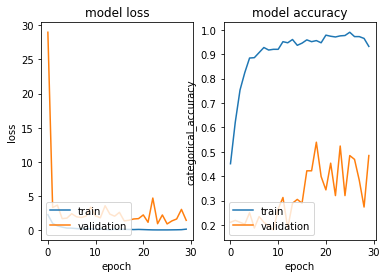

In [24]:
def plot_history(training_history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(training_history.history['loss'])
    axes[0].plot(training_history.history['val_loss'])
    axes[0].set_title('Model Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper right')

    axes[1].plot(training_history.history['categorical_accuracy'])
    axes[1].plot(training_history.history['val_categorical_accuracy'])
    axes[1].set_title('Model Accuracy')
    axes[1].set_ylabel('Categorical Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

plot_history(history)

In [25]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [26]:
optimiser = Adam(learning_rate=0.01) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 10, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3505 - categorical_accuracy: 0.3765
Epoch 00001: saving model to model_init_exp_02_2024-02-0620_21_19.404987/model-00001-1.35049-0.37649-1.50370-0.14844.h5
21/21 [==============================] - 55s 3s/step - loss: 1.3505 - categorical_accuracy: 0.3765 - val_loss: 1.5037 - val_categorical_accuracy: 0.1484 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1046 - categorical_accuracy: 0.5119
Epoch 00002: saving model to model_init_exp_02_2024-02-0620_21_19.404987/model-00002-1.10461-0.51190-1.81322-0.17188.h5
21/21 [==============================] - 50s 2s/step - loss: 1.1046 - categorical_accuracy: 0.5119 - val_loss: 1.8132 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.0985 - categorical_accuracy: 0.5268
Epoch 00003: saving model to model_init_exp_02_2024-02-0620_21_19.404987/model-00003-1.09847-0.52679-1.57575-0

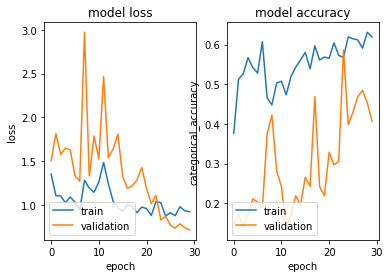

In [28]:
plot_history(history)